# **The Ecosystem Object Definition**

The ecosystem is a virtual environment in a virtual universe in which virtual robots are created by the **_Chief Robot Programmer_** (CRP). The ecosytem has 'rules' which, if the robots do not follow, they can come to a premature demise. It is up to the CRP to programme their robots to follow system rules. A well programmed robot colony can thrive and prosper, if it is poorly programmed it may not perform so well.

There are a number of system indicators which measure the health of the ecosystem. 

During the lifetime of the universe the ecosystem might evolve. This means the ecosystem rules change. Robots must therefore evolve or adapt to their new environment. The CRPs must be agile programmers.

A major deadline exists on the 12-January-2022. There will be a major conference of the parties or **COP27** meeting to see whether your ecosystem is on track to meet targets and deliver a sustainable Robot ecosystem which is operating in harmony with its environment by creating a circular economy.


# **Ecosystem Version -  Final Release**

**WSA010_Coursework_V3_2 (30) 16-Dec-21 13:00**

## **Required Imports**

In [1]:
#@title Required Imports [code] {display-mode: "code"}
from IPython.display import clear_output
from copy import copy, deepcopy
import time
from random import randint
from sys import exit
import numpy as np
import matplotlib.pyplot as plt
import math
from queue import Queue
#from types import type - may need later

## **Globals**

Global variables used in the code base. Do not adjust these.

In [2]:
#@title Globals [code] {display-mode: "code"}

testing = False

#Ecosystem Boundaries
default_width = 80
default_height = 40
default_altitude = 5

arena_limits = (default_width,default_height,default_altitude)

#Fading of robots  alpha = m_fade * soc/capacity + c_fade
c_fade = 0.1
m_fade = 0.9 - c_fade
#deliverable fading
delivered_fade = 0.33
delivered_fade_rate = .005   #d alpha at -.5% per update

#maximum damage a robot can sustain
max_damage = 5
motion_efficiency = 0.100
system_efficiency = 0.025

NL = "\n"
TB = "\t"
PR = ">"



In [3]:

randcoordinates = [randint(0,m) for m in list(arena_limits[:2]) + [0]]
print (randcoordinates)

[34, 34, 0]


## **Support Functions**

The ecosystem requires all these sections to operate. Do not remove and ensure they are run before developing and running your Robots

In [4]:
# @title Utility functions [code] {display-mode: "code"}

#randsign generates a random -1 or +1 to give a random sign of a vector
def randsign():
    return [-1,1][randint(0,1)]

#sign returns the sign x 1 of a number.
def sign(i):
    #return [-1,1][i>0]
    return [-1,0,1][0 if i < 0 else 1 if i == 0 else 2]

#Returns the name of a variable in the namespace which points to the passed object.
#If more than name points to the object the first is returned or all if return_all is true
def namestr(obj, return_all = False):
    namespace = globals()
    if return_all:
        return [name for name in namespace if namespace[name] is obj]
    else:
        try:
            return [name for name in namespace if namespace[name] is obj][0]
        except:
            return obj # probably a literal so no name to give!

Text(0.5, 1.0, 'Normalised Irradiance')

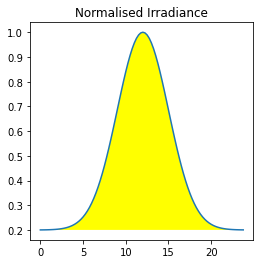

In [5]:
# @title Irradiance [code] {display-mode: "code"}
#Not a real estimate of irradiance since it isn't gaussian
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    pdf = num/denom
    return pdf

def irradiance(hour):
    hour = hour % 24
    mean = 12     #mid-day
    sd = 3        #standard dev of irradiance
    normalised_pdf  = normpdf(hour,mean,sd)/normpdf(mean,mean,sd)
    moonlight = 0.2
    a = moonlight + (1-moonlight)*normalised_pdf
    return a

#Test Display of irradiance over 24 hours
x,i = [],[]
for h in range(0,24*4):
    i.append (irradiance(h/4))
    x.append (h/4)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
a = ax.plot(x,i)
a = ax.fill(x,i,'yellow')
plt.title ('Normalised Irradiance')




### **Defaults**
This section defines default values for different Robot and other Ecosystem Objects. CRPs should study this section to understand the different default values assigned to
robots of difference types.

In [6]:
#@title Validation Lists {display-mode: "code"}

####################
## DEFAULTS       ##
####################

# Matplotlib colors and shapes semantics # https://matplotlib.org/stable/api/markers_api.html
mpl_shapes = {'square':'s', 'circle':'o','triangle':'^', 'plus':'P', 'star':'*', 'diamond':'D', 'x':'x', 'hexagon':'h'}
mpl_colors = {'blue': 'b', 'green': 'g', 'red': 'r', 'cyan': 'c', 'magenta': 'm', 'yellow': 'y', 'black': 'k', 'white': 'w'}

colors = [color for color in mpl_colors]
shapes = [shape for shape in mpl_shapes]

modes = ['required', 'default', 'validation','function', 'datatype', 'description']

kinds = dict(
    Robot = 'Robot', 
    Droid = 'Robot', 
    Drone = 'Robot', 
    Pizza = 'Deliverable', 
    Grid_Charger = 'Station',
    Solar_Charger = 'Station', 
    Repair_Station = 'Station', 
    Recycling_Station = 'Station')

robot_statuses = [
	'off', 
	'on', 
	'broken']

deliverable_statuses = [
	'awaiting_transport',
	'awaiting_collection', 
	'in_transit',
	'delivered']

station_statuses = [
	'occupied', 
	'vacant']

activities = [
	'idle',
	'available', 
	'charging', 
	'busy', 
	'delivering', 
	'is_cargo', 
	'under_repair',
	'repairing']




In [7]:
#@title Validation Functions [code] {display-mode: "code"}
#nv = new value
# v = old value
#av = rule parameters 
length = lambda nv,v,av: (av[0] <= len(nv) <= av[1],nv if av[0] <= len(nv) <= av[1] else v)  #return old value if new invalid
inlist = lambda nv,v,av: (nv in av, nv if nv in av else v)     
nochange = lambda nv,v,av: (nv == v, v)
inrange = lambda nv,v,av: (av[0] <= nv <= av[1],nv if av[0] <= nv <= av[1] else v)
listdelta = lambda nv,v,av:(False not in [abs(i_nv - i_v) <= i_av for i_nv, i_v, i_av in zip(nv,v,av)], v)
listmaxdelta = lambda nv,v,av:(False not in [abs(i_nv - i_v) <= i_av for i_nv, i_v, i_av in zip(nv,v,av)], [ i_v + [-1,1][i_nv > i_v]*min(i_av,abs(i_nv-i_v)) for i_nv, i_v, i_av in zip(nv,v,av)])
onarena = lambda coordinates: (False not in [0 <= i_c <= i_l for i_c, i_l in zip(coordinates, arena_limits)], [i_c if 0 <= i_c <= i_l else -1 if i_c < 0 else i_l + 1 for i_c, i_l in zip(coordinates, arena_limits)])
listmax = lambda nv,v,av: (False not in [abs(nv[i]) <= av[i] for i in [0, 1, 2]], [nv[i] if abs(nv[i]) <= av[i] else av[i]*sign(nv[i]) for i in [0, 1, 2]])
none = lambda nv,v,av: (True,nv)

def validxyz(nv,v,av):
    #nv for new robot receives v = nv
    #av = [dx,dy,dz]  where dz >= 1 means volitant and cannnot move on the ground
    if av[2] >= 1 and nv[2] == 0 and v[2] == 0:    #volitant is on the ground and was previously
        return nv == v, v                            # if not equal then this is false so bad move
    else:    
        deltaOK, cnv = listmaxdelta(nv,v,av)  #corrected new values wrt to vector increments
        on_arena, anv = onarena(cnv)
        return deltaOK and on_arena, anv

validation_functions = {'none': none, 'listmax': listmax, 'inlist': inlist, 'nochange': nochange, 'inrange': inrange, 'listdelta': listdelta, 'listmaxdelta': listmaxdelta, 'onarena': onarena, 'validxyz': validxyz, 'length': length }

def validation(new_value, old_value, rule, function_name, verbose = True):
    proposed_value = new_value
    function = validation_functions[function_name]
    valid, new_value = function (new_value, old_value, rule)
    if verbose:
        if valid:
            if old_value == new_value:
                message = 'Value \'' + str(old_value) + '\' retained'
            else:
                message = 'Value \'' + str(old_value) + '\' set to \'' + str(new_value) + '\''
        else:
            message = 'Value \'' + str(proposed_value) + '\' rejected. ' 
            if function_name == 'length':
                message += 'Length must be between ' + str(rule[0]) + ' and ' + str(rule[1])
            if function_name == 'inrange':
                message += 'Must be between ' + str(rule[0]) + ' and ' + str(rule[1])
            elif function_name == 'inlist':
                message += 'Must be in list ' + str(rule)
            elif function_name == 'nochange':
                message += 'Cannot be changed from \'' + str(old_value) + '\''
            elif function_name == 'validxyz':
                message += 'Coordinate value or change not permitted'
                message += '. Set to ' + str(new_value) + '.'
    else:
        message = ''
        return valid, new_value, proposed_value, message

#unit tests
if False and testing:
    print (validation('xyx',None,'none','none'))
    print (validation([75, 16, 0],[78, 16, 0],[2,2,0],'none'))
    print (validation([75, 16, 0],[78, 16, 0],[2,2,0],'listmaxdelta'))
    print (validation('squre', 'triangle', shapes, 'inlist'))
    print (validation('square','triangle',shapes,'inlist'))
    print (validation('pink','red',colors,'inlist'))  
    print (validation(1,1,0,'nochange'))
    print (validation(1,2,0,'nochange'))
    print (validation([23],[24],0,'nochange'))  
    print (validation([23],[23],0,'nochange'))  
    print (validation(800,300,[200,900],'inrange'))
    print (validation(100,300,[200,900],'inrange'))  
    print (validation(1000,300,[200,900],'inrange'))    
    print (validation('shouldsucceed','testing',[3,20],'length'))
    print (validation('01234567890','shouldfail',[3,10],'length'))
    print (validation('01','shouldfail',[3,10],'length'))
    print (validation([78, 16, 0],[78, 16, 0],[2,2,0],'validxyz'))  #no change
    print (validation([77, 16, 0],[78, 16, 1],[2,2,1],'validxyz'))  #ok change
    print (validation([76, 17, 0],[78, 16, 0],[1,1,0],'validxyz'))  #too big
    print (validation([78, 14, 0],[78, 16, 0],[1,1,0],'validxyz'))  #too big  
    print (validation([56, 33, 0],[53, 36, 0],[3,3,1],'validxyz'))
    print (validation([1, 1, 0],[2, 2, 0],[2,2,0],'listmax'))
    print (validation([2, 2, 0],[2, 2, 0],[2,2,0],'listmax'))
    print (validation([-2, -2, 0],[2, 2, 0],[2,2,0],'listmax'))
    print (validation([-1, -1, 0],[2, 2, 0],[2,2,0],'listmax'))
    print (validation([-3, -3, 0],[2, 2, 0],[2,2,0],'listmax'))
    print (validation([2, 2, 1],[2, 2, 0],[2,2,0],'listmax'))



In [8]:
#@title Defaults [code] {display-mode: "code"}

####################
## ROBOT_DEFAULTS ##
####################

#robot_default returns a dictionary of robot instance variables, and properties 
#for these attributes

def robot_default (kind, mode = 'default'):

    kind_class = kinds[kind]
    dictionary = {}

    dictionary['kind'] = ['required', kind, 0, 'nochange', 'string', 'robot class type']
    if kind_class == 'Station':
        dictionary['coordinates'] = ['required', [0, 0, 0], [0, 0, 0 ], 'validxyz', 'list', 'x, y, z location of a robot']
        dictionary['max'] = ['required', [0, 0, 0], 0, 'nochange', 'list', 'maximum x, y, z velocity']
        dictionary['velocity'] = ['required', [0, 0, 0], [0 ,0 ,0], 'listmax', 'list', 'current  x, y, z velocity']
        dictionary['status'] = ['required', 'vacant',station_statuses, 'inlist', 'string', 'Set to on, off or broken']
        dictionary['activity'] = ['required', 'idle', activities, 'inlist', 'string', 'determines activity of station']
        dictionary['size'] = ['optional', 300, [250,1000], 'inrange', 'integer', 'arena display size']
        dictionary['alpha'] = ['optional', 1, 0, 'nochange', 'float', 'arena display transparency']
        dictionary['damage'] = ['recommended', 0, 0, 'nochange', 'integer', 'damage points accrued by station']
        dictionary['occupant'] = ['recommended', 0, 0, 'nochange', 'integer', 'damage points accrued by station']
    if kind == 'Grid_Charger':
        dictionary['name'] = ['required', 'gazza', [2,20], 'length', 'string', 'named of robot']
        dictionary['shape'] = ['optional', 'diamond', shapes, 'inlist', 'string', 'arena display shape']
        dictionary['color'] = ['optional', 'blue', colors, 'inlist', 'string', 'arena display colour']
    elif kind == 'Solar_Charger':
        dictionary['name'] = ['required', 'sunny', [2,20], 'length', 'string', 'named of robot']
        dictionary['shape'] = ['optional', 'diamond', shapes, 'inlist', 'string', 'arena display shape']
        dictionary['color'] = ['optional', 'green', colors, 'inlist', 'string', 'arena display colour']
    elif kind == 'Repair_Station':
        dictionary['name'] = ['required', 'fixit', [2,20], 'length', 'string', 'named of robot']
        dictionary['shape'] = ['optional', 'diamond', shapes, 'inlist', 'string', 'arena display shape']
        dictionary['color'] = ['optional', 'magenta', colors, 'inlist', 'string', 'arena display colour']
    elif kind == 'Recycling_Station':
        dictionary['name'] = ['required', 'reuse', [2,20], 'length', 'string', 'named of robot']
        dictionary['shape'] = ['optional', 'diamond', shapes, 'inlist', 'string', 'arena display shape']
        dictionary['color'] = ['optional', 'cyan', colors, 'inlist', 'string', 'arena display colour']

    elif kind_class == 'Deliverable':
        dictionary['coordinates'] = ['required', [0, 0, 0], [0, 0, 0 ], 'validxyz', 'list', 'x, y, z location of a robot']
        dictionary['max'] = ['required', [0, 0, 0], 0, 'nochange', 'list', 'maximum x, y, z velocity']
        dictionary['velocity'] = ['required', [0, 0, 0], [0 ,0 ,0], 'listmax', 'list', 'current  x, y, z velocity']
        dictionary['status'] = ['required', 'awaiting_transport',deliverable_statuses, 'inlist', 'string', 'Set to on, off or broken']
        dictionary['activity'] = ['required', 'idle', activities, 'inlist', 'string', 'determines activity of deliverable']
        dictionary['size'] = ['optional', 300, [250,1000], 'inrange', 'integer', 'arena display size']
        dictionary['alpha'] = ['optional', 1, 0, 'nochange', 'float', 'arena display transparency']
        dictionary['weight'] = ['optional', 50, [25,1000], 'nochange', 'integer', 'weight of deliverable']
        dictionary['damage'] = ['recommended', 0, 0, 'nochange', 'integer', 'damage points accrued by deliverable']  
        dictionary['name'] = ['required', 'pizza', [2,20], 'length', 'string', 'named of deliverable']
        dictionary['target'] = ['recommended', None,'none', 'none', 'list', 'x, y, z of delivery destination']    
        dictionary['shape'] = ['optional', 'circle', shapes, 'inlist', 'string', 'arena display shape']
        dictionary['color'] = ['optional', 'white', colors, 'inlist', 'string', 'arena display colour']
        dictionary['transport'] = ['optional', None,'object', 'nochange', 'object', 'object robot is transporting']
        dictionary['start'] = ['optional', 0, 0, 'none', 'float', 'start time stamp']
        dictionary['end'] = ['optional', 0, 0, 'none', 'float', 'end time stamp']

    elif kind_class == 'Robot':
        dictionary['coordinates'] = ['required', [0, 0, 0], [1, 1, 0 ], 'validxyz', 'list', 'x, y, z location of a robot']
        dictionary['max'] = ['required', [1, 1, 0], 0, 'nochange', 'list', 'maximum x, y, z velocity']
        dictionary['velocity'] = ['required', [0, 0, 0], [1 ,1 ,0], 'listmax', 'list', 'current  x, y, z velocity']
        dictionary['status'] = ['required', 'on',0, 'nochange', 'string', 'Set to on, off or broken']
        dictionary['activity'] = ['required', 'idle', activities, 'inlist', 'string', 'determines activity of robot']
        dictionary['name'] = ['required', 'id', [2,20], 'length', 'string', 'named of robot']
        dictionary['target'] = ['recommended', None,'none', 'none', 'list', 'x, y, z of a target destination']
        dictionary['age'] = ['recommended', 0, 0, 'nochange','integer', 'age of robot in hours']
        dictionary['active'] = ['recommended', 0, 0, 'nochange','integer', 'active hours of robot']    
        dictionary['serviced'] = ['recommended', 0, 0, 'nochange','integer', 'age of robot at last service']
        dictionary['soc'] = ['recommended', 600, 0, 'nochange', 'integer', 'state of charge of battery']
        dictionary['capacity'] = ['recommended', 600, 0, 'nochange', 'integer', 'energy capacity of robot battery']
        dictionary['service'] = ['recommended', 0, 0, 'nochange', 'integer', 'service points accrued by robot']
        dictionary['damage'] = ['recommended', 0, 0, 'nochange', 'integer', 'damage points accrued by robot']
        dictionary['on_arena'] = ['optional', 0,0, 'nochange', 'boolean', 'True if robot is on the arena']
        dictionary['shape'] = ['optional', 'square', shapes, 'inlist', 'string', 'arena display shape']
        dictionary['color'] = ['optional', 'blue', colors, 'inlist', 'string', 'arena display colour']
        dictionary['size'] = ['optional', 250, [250,1000], 'inrange', 'integer', 'arena display size']
        dictionary['alpha'] = ['optional', 1, 0, 'nochange', 'float', 'arena display transparency']
        dictionary['weight'] = ['optional', 50, 0, 'nochange', 'integer', 'weight of robot']
        dictionary['payload'] = ['optional', 100, 0, 'nochange', 'integer', 'maximum load of robot']
        dictionary['cargo'] = ['optional', None,'object', 'none', 'object', 'object robot is transporting']
        dictionary['station'] = ['optional', None,'object', 'none', 'object', 'station robot is heading for']
        dictionary['distance'] = ['optional', 0, 0, 'nochange', 'float', 'distance travelled by robot']
        dictionary['energy'] = ['optional', 0, 0, 'nochange', 'float', 'energy consumed by robot']

    if kind == 'Droid':
        dictionary['coordinates'][2] = [2, 2, 0 ]
        dictionary['max'][1] = [2, 2, 0 ]
        dictionary['velocity'][2] = [2, 2, 0 ]
        dictionary['soc'][1] = 2000
        dictionary['capacity'][1] = 2000
        dictionary['shape'][1]= 'circle'
        dictionary['color'][1] = 'red'
        dictionary['size'][1] = 300
        dictionary['weight'][1] = 100
        dictionary['payload'][1] = 200
    elif kind == 'Drone':
        dictionary['coordinates'][2] = [3, 3, 1]
        dictionary['max'][1] = [3, 3, 1]     
        dictionary['velocity'][2] = [3, 3, 1 ]    
        dictionary['soc'][1] = 500      
        dictionary['capacity'][1] = 500
        dictionary['shape'][1] = 'triangle'
        dictionary['color'][1] = 'green'
        dictionary['size'][1] = 500
        dictionary['weight'][1] = 25
        dictionary['payload'][1] = 50
    dictionary['kind_class'] = ['optional', kind_class, 0, 'nochange', 'string', 'class of kind']

    try:
        if mode == 'dictionary':
            return dictionary
        elif mode == 'keys':
            return tuple(key for key in dictionary)
        else:
            index = modes.index(mode)                                      
            return {key: value[index] for key, value in dictionary.items()}
    except:
        pass

  


In [18]:
#@title Defaults Tests [code] {display-mode: "code"}
local_testing = True and testing
if local_testing:
    for kind in kinds.keys():    #  ['Robot','Droid','Drone']:
        for return_type in ['dictionary','default']:
          print(kind, return_type,robot_default(kind, return_type))
    for return_type in ['keys', 'required', 'validation','function','datatype', 'description']:   
        print(return_type,robot_default('Robot', return_type))

    print ('Deliberate Error Raise test:')
    print ('Invalid mode:',robot_default('Robot','key'))

### **Display**

The display is designed to display individual robots on the robot arena. It receives a list of robot registers when ```ecosystem.display()``` is executed. Display is documented in the Ecosystem documentation.





In [19]:
# @title Display Function [code] {display-mode: "code"} 
#%matplotlib inline

def display(markers,**kwargs):
    cm = 1/2.54
    width = kwargs.get('width', 30)*cm
    height = kwargs.get('height', 15)*cm
    pause = kwargs.get('pause', 250)
    title = kwargs.get('title','Ecosystem Display')
    clear = kwargs.get('clear',True)
    hour =  kwargs.get('hour', 12)
    brightness = kwargs.get('brightness', False)
    facecolor =  kwargs.get('facecolor', 'yellow')
    annotations = kwargs.get('annotations', [])
    annotate = len(annotations) > 0
    if annotate:
        try:
            if type(annotations[0]) == tuple:
                dx,dy = annotations[0][0],annotations[0][1]
            else:
                dx,dy = 1, 1
        except:
            pass

    try:
        title = title.format(**kwargs)
    except Exception as error:
        title = title + ' #format missing ' + str(error) + '#'

    x_max =  default_width
    y_max =  default_height

    if clear:
        clear_output(wait=True)

    a = irradiance(hour) if brightness else 1


    fig = plt.figure(figsize=(width,height))
    fig.patch.set_facecolor('grey')
    fig.patch.set_alpha(0.6)
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor(facecolor)
    ax.patch.set_alpha(a)

    plt.title (title)
    plt.xlim(-2, x_max+2)
    plt.ylim(-2, y_max+2)
    for p in markers:
        try:
            x=p['coordinates'][0]
            y=p['coordinates'][1]
            scale = p['size']
            color = p['color'] 
            shape = p['shape']
            alpha = p['alpha']
            marker_shape = mpl_shapes[shape] 
            ax.scatter(x, y, s=scale, c=color, marker=marker_shape, alpha=alpha, edgecolors='b')
            if p['coordinates'][2] > 0:
                ax.scatter(x, y, s=scale*3, c='k', marker='1', alpha=alpha, edgecolors='b')    #add helcoptor wings
            if annotate:
                try:
                    annotation =  ';'.join(key + ":" + str(value) for key, value in p.items() if key in annotations)
                    plt.annotate(annotation, (x+dx, y+dy),)
                except:
                    pass

        except Exception as error:
            #print("Point error:", p, error)
            continue

    ax.set_xticks(range(0, x_max + 1, 10))
    ax.set_yticks(range(0, y_max + 1, 10))
    ax.grid(color = 'red', linestyle = '--', linewidth = 0.25)

    plt.show()
    time.sleep(pause/1000)



In [11]:
#@title Display Tests {display-mode: "code"}
if testing:
    points = []

    for kind in ['Robot', 'Drone', 'Droid', 'Grid_Charger', 'Solar_Charger','Repair_Station','Recycling_Station', 'Pizza', 'Pizza']:
        register = robot_default(kind, 'default')
        alt_max = 1 if kind == 'Drone' else 0
        register['coordinates'][0] = randint (0, default_width)
        register['coordinates'][1] = randint (0, default_height)
        register['coordinates'][2] = randint (0, alt_max)
        points.append(register)

    display(points, facecolor = 'pink',title = "Ecosystem Display Hour:{hour} Registered:{registered}", annotations = [(1.5,0),'soc','name'], hour = 12, registered = len(points))
    for p in points:
        print (p)
  

## **Ecosystem Class**




In [12]:
########################################################
# @title Ecosystem Class [code] {display-mode: "code"}
########################################################

class Ecosystem:
    def __init__(self):
        #Constructor - called when a new object is created using the class
        #Attributes or properties
        self._duration = 24
        self._hour = 0
        self._robots = []
        self.display_on_update = False
        self._register = {}
        self.markers = []
        self._messages = Queue()
        self._cache = {}
        self._registerable = [ kind for kind in kinds]
        self.random_cordinates = True
        self.message_types = [ 'damage', 'error', 'info', 'broken']     #''warning''
        self._display_parameters = {}
        self._delivered = {}  #cache of delivered objects transferred from live register

####################
##   Properties   ##
####################

    @property 
    def display_parameters(self):
        return self._display_parameters

    @display_parameters.setter
    def display_parameters(self, parameters):
        self._display_parameters = parameters

    @property
    def has_message(self):
    return not self._messages.empty()   #while not q1.empty():
    @property
    def messages(self):
    text = ''
    while self.has_message:
    #messages are a tuple of 5 objects
    message_type, kind, name, function, comment = self.message
    try:
    text += f'{message_type:<10} {kind:<8} {str(name):<16} {function[:12]} {comment}' + '\n'
    except:
    text += str([message_type, kind, name, function, comment])
    return text
    @property
    def message(self):
    if self._messages.empty():
    return False
    else:
    return self._messages.get()
    @message.setter
    def message(self, value):
    try:
    if value[0] in self.message_types:
    self._messages.put(value)
    except TypeError:
    pass
    @property
    def robots(self):
    return [robot for robot in self._robots if robot.kind in ['Robot', 'Droid', 'Drone']]
    def things (self, kind):
    return [thing for thing in self._robots if thing.kind == kind]
    @property
    def robot_register(self):
    return self._register
    @property
    def duration(self):
    return self._duration
    @duration.setter
    def duration(self, value):
    self._duration = value
    @property
    def hour(self):
    return self._hour
    @property
    def count_operational(self):
    count = len([value for value in self._register.values() if value['status'] == 'on'])
    return count
    @property
    def stop(self):
    return self._hour>self._duration
    @property
    def operational(self):
    return self.count(status = 'on')
    @property
    def broken (self):
    return self.count(status = 'broken')

    ####################
    ##   Object       ##
    ####################

    def create(self, kind, coordinates = [0,0,0]):
    def object_init(self,dictionary):
    for k, v in dictionary.items():
    setattr(self, k, v)

    try:
    if kind in self._registerable:       #<-Check if a registerable object
    register = robot_default(kind)
    New_Object = type(kind,(),{"__init__":object_init})   #lambda self,dictionary: (setattr(self, k, v) for k, v in dictionary.items()) tried to use but Lambda cannot return None which init expects
    new_object = New_Object(register)

    if new_object.kind_class == 'Deliverable':
    if coordinates != [0,0,0]:
    raise ValueError("Robot controllers cannot decide where to collect a " + kind)
    new_object.target = [randint(0,default_width), randint(0,default_height), 0]

    new_object.coordinates[0] = coordinates [0]
    new_object.coordinates[1] = coordinates [1]
    new_object.start = ecosystem.hour
    self.register(new_object)
    return new_object
    else:
    raise TypeError("The ecosystem can't create a " + str(kind))
    except Exception as error:
    print('>>', 'create error')
    self.message = ('error', kind, 'None', 'create', error)

    ####################
    ##   METHODS      ##
    ####################
    def help(self):
    for a in [a for a in dir(self) if not a.startswith('_') and callable(getattr(self, a))]:
    print (a)

    def count (self, **kwargs):
    count = len(self.registry(**kwargs))
    return count

    def registry(self, **kwargs):
    if kwargs == {}:
    return self._register
    else:
    try:
    return {key: value for key, value in self._register.items() if (False not in [value[filter_key] == filter_value for filter_key, filter_value in kwargs.items()])}
    except Exception as error:
    return "Could not filter register using "   + str(kwargs) + ' ' + str(error)

    ##   DISPLAY       ##
    def display (self):
    markers = self._get_markers()

    title = self.display_parameters.get('title')
    if title is not None:
    for word in title.split():
    print(word)
    if word[0] == "{" and word[-1] == "}":
    attribute = word[1:-1]
    self.display_parameters[attribute] = getattr(self, attribute,'#error#')
    print (attribute, self.display_parameters[attribute] , getattr(self, attribute,'#error#'))
    display(markers, **self.display_parameters)

    ##   MARKERS       ##
    def _get_markers(self):
    self.markers = [value for value in self._register.values()]
    return self.markers

    ##   REGISTER  ##
    def register (self, *args):
    for robot in args:
    kind = type(robot).__name__
    if kind in self._registerable:       #<-Check if a registerable object
    if robot in self._robots:          #<-Check if already in the register
    self.message = ('warning', kind, robot.name, 'register', 'already registered')
    else:
    try:                            #\>Try get default from cache
    dictionary = self._cache[kind]
    except:                         #/>auto heal the cache
    dictionary = robot_default(kind, 'dictionary')
    self._cache[kind] = dictionary

    #Get a new register copy from the dictionary. Upgrade Caution - index for default values fixed to 1
    register = deepcopy({key: value[1] for key, value in dictionary.items()})

    #Resolve co-ordinate updating
    #if the user has provided coordinates check if these are defaults and if not, set to defaults
    coordinates = getattr(robot,'coordinates', register['coordinates'])
    #if the coordinates are defaults and they should be random then randomize x and y.
    if register['coordinates'] == coordinates and self.random_cordinates:
    coordinates[0] = randint(0,default_width)
    coordinates[1] = randint(0,default_height)
    try:
    #update the object with the new random co-ordinates.
    #do not detect and error here as that will come in the round later
    setattr( robot,'coordinates', coordinates)
    except:
    pass
    #reset xy coordinates in the register to reflect changes and prevent speeding
    #however drones cannot start with z>1 so let error handling pick that up
    register['coordinates'][0] = coordinates[0]
    register['coordinates'][1] = coordinates[1]

    for key, register_value in register.items():
    value = dictionary[key]
    #sequence unpack the dictionary value list with indexes  0,2,3
    required, rule, function_name = [value[index] for index in [0,2,3]]
    try:
    new_value = getattr(robot, key)         #exception if not an available instance variable
    valid, new_value, proposed_value, message = validation (new_value, register_value, rule, function_name)
    if valid == False:
    self.message = ('damage', kind, id(robot), 'register', '\'' + key + '\' error: ' + message)
    register['damage'] += 1
    if hasattr (robot,'damage'):
    setattr(robot,'damage', register['damage'])
    register[key] = copy(new_value)         #even tho proposed_value may be rejected, new_value is always good so update it!'
    except Exception as error:
    if required == 'required':              #required instance variable not present
    self.message = ('error', kind, id(robot), 'register', 'required variable \'' + key + '\' missing. ' + kind + ' not registered')
    break
    elif required == 'recommended':         #recommened instance variable not present
    self.message = ('warning', kind, id(robot), 'register', 'recommended variable \'' + key + '\' missing')
    else:                                       #rare use of else. Register robot if no break executed
    self._robots.append(robot) 
    self._register[id(robot)] = register
    self.message = ('info', kind, id(robot), 'register', kind + ' registered with ' + str(register['damage']) + ' damage points' )
    else:
    self.message = ('error', kind, id(robot), 'register', 'attempt to register an invalid object type')
    #/if kind in self._registerable
    #/for robot in args  

    def deregister (self, *args):
    for robot in args:
    try:
    del self.robot_register[id(robot)]
    self.robots.remove(robot)
    del robot
    except:
    pass

    ## UPDATE ##
    def update(self):
    for robot in self.robots:                             #note - robots now contains pizzas, so use the internal property which filters
    dictionary = self._cache[robot.kind]                #get the dictionary for validation purposes
    register = self._register[id(robot)]                #get the current register
    coordinates = copy(register['coordinates'])         #used for later distance calculation
    if register['status'] == 'on':                      #if 'on' update new register from robot, ignore if not present
    for key, register_value in register.items():
    try:
    robot_value = getattr(robot, key)         #exception if not an available instance variable
    if robot_value != register_value:
    value = dictionary[key]
    required, rule, function_name = [value[index] for index in [0,2,3]]
    valid, validated_value, proposed_value, message = validation (robot_value, register_value, rule, function_name)
    #print(">>>", valid, validated_value, proposed_value, message )
    if valid == False:
    self.message = ('damage', robot.kind, id(robot), 'update', '\'' + key + '\' error: ' + message)
    register['damage'] += 1
    if hasattr (robot,'damage'):
    setattr(robot,'damage', register['damage'])
    #register[key] = copy(validated_value)         #even tho proposed_value may be rejected, new_value is always good so update it!'                  
    #somethings making the coordinates the same so checking this line: with copy
    register[key] = validated_value         #even tho proposed_value may be rejected, new_value is always good so update it!'
    except Exception as error:
    #print (error)
    pass

    # increment age regardless of anything
    register['age'] += 1

    if register['status'] == 'on':
    register['active'] += 1
    cargo_weight = 0
    cargo = register['cargo']
    if cargo is not None:
    if cargo.status == 'awaiting_transport':
    if cargo.coordinates != register['coordinates']:  
    cargo.status = 'awaiting_collection'
    if cargo.status == 'awaiting_collection':
    if cargo.coordinates == register['coordinates']:
    #robot has arrived at collection point, so load up.
    cargo.status = 'in_transit'
    cargo.size = 200
    cargo.shape = 'square'
    cargo.color = 'red'
    cargo_weight = cargo.weight
    if cargo.status == 'in_transit':
    cargo.coordinates = copy(register['coordinates'])
    if cargo.coordinates == cargo.target:
    #arrived at destination
    cargo.status = 'delivered'
    cargo.color = 'white'
    cargo.shape = 'circle'
    cargo.alpha = delivered_fade
    cargo.end = ecosystem.hour
    register['service'] += cargo.weight
    self._register[id(cargo)] = cargo.__dict__

    #Charging station
    station = register['station']
    if station is not None:  
    if station.status == 'vacant':
    if station.coordinates == register['coordinates']:
    station.status = 'occupied'
    station.occupant = robot
    station.color = 'cyan'
    station.size = 1000
    elif station.status == 'occupied':
    if station.occupant is robot:
    register['soc'] = register['capacity']
    station.status = 'vacant'
    station.occupant = None
    station.color = 'blue'
    station.size = 250
    self._register[id(station)] = station.__dict__

    #using cache of coped coordinates becasue validation destroys change for calculation of distance      
    distance = round(((register['coordinates'][0] - coordinates[0])**2 + (register['coordinates'][1] - coordinates[1])**2)**.5,1)      
    register['distance'] += distance

    height = max(robot.coordinates[2] - register['coordinates'][2],0) #not used in energy calcs yet!

    motion_energy = (register['weight'] + cargo_weight) * distance * motion_efficiency
    system_energy = register['weight'] * system_efficiency
    energy = int(min(system_energy + motion_energy, register['soc']))
    register['energy'] += energy
    register['soc'] = int(register['soc'] - energy)
    #register['soc'] = round(max(register['soc'], 0),2)



    if onarena(register['coordinates'])[0] == False:
    register['damage'] += max_damage
    self.message = ('damage', robot.kind, robot.name, 'update', 'damage at ecosystem boundary') 
    if register['damage'] >= max_damage:
    self.message = ('broken', robot.kind, robot.name, 'update', 'max damage score')
    register['status'] = 'broken'
    if register['soc'] < 1:
    if station is not None and station.coordinates == register['coordinates']:
    #low charge robot is in queu for charger so do not break
    self.message = ('warning', robot.kind, robot.name, 'update', 'out of power in charger queue') 
    else:
    register['status'] = 'broken'
    self.message = ('broken', robot.kind, robot.name, 'update', 'out of power') 

    if register['status'] == 'broken':
    register['alpha'] = 0.2
    print ('broken', register)
    else:
    #alpha  determines the transparency of robots. Running out of fuel makes robots fade
    register['alpha'] = m_fade * register['soc']/register['capacity'] + c_fade
    # End of status != off block 

    for key, value in register.items():    # updating available Robot attributes
    if hasattr(robot,key):
    if key == 'coordinates':
    setattr(robot,key,copy(value))
    #setattr(robot,key,copy(value))
    else:
    setattr(robot,key,value)

    #remove faded delivered to the delivered cache and
    delivered = {key:value['alpha'] for key, value in self._register.items() if value['status'] == 'delivered'}
    for key, alpha in delivered.items():
    if alpha == 0:
    self._delivered[key] = ecosystem.robot_register.pop(key)  #transfer
    else:
    ecosystem.robot_register[key]['alpha'] = max(alpha - delivered_fade_rate, 0)

    self._hour += 1  
    if self.display_on_update:
    self.display()



#**Ecosystem Documentation** 




##**Policies**
---
The Ecosystem system sets a standard for design policies which all CRPs must adhere too.

* For security **only** use instance variables should be use and class variables should be deprecated, i.e. those defined and assigned in the constructor method.

* Robot Classes must be self contained within their own code cells for clarity of purpose and assessment, commented as appropriate. Instantiation and registration testing of classes should be separate

* Where appropriate CRPs should augment code cells comments with text cells to document and explain designs for third parties and assessment in the final submission.





## **Ecosystem Rules**

_The current version rules are as follows_

___
Rules are only enforced when an ecosystem.update() call is made. All attributes are inspected, and values and changes are validated.

**Registerable Objects**

Only objects with the following (case sensitive) class names can be registered.
```
 Robot
 Droid
 Drone
```
Attempts to register anything fails. Registration failure wastes ecosystem finite resources.

**Required Attributes**
Objects must have the required attributes as documented in the Robot Class Specifications. Absence of required attributes causes registration failure. Registration failure wastes ecosystem finite resources!

**Read Only**

You can implement, in your Robots any of the attributes in the Robot attributes tables. A large number are read only. You can only set the value to the default value prior to registering a new robot with the ecosystem. Attempts to change a read-only values cause damage. Robots accrue 1 damage point per change attempt.

**Speed**

Robots must not move more than the following increments between updates in the $x$, $y$ and $z$  directions. You can regard this as a nominal maximum speed, though of course moving diagonally is permitted and this increases the speed by factor of  $\sqrt{2}$ (if $\Delta x=1$ and $\Delta y = 1$). This is permitted. The main point is to adhere to permitted $x$, $y$ or $z$ increments.

|       | 𝜟x | 𝜟y | 𝜟z |
|:-----:|:--:|:--:|:--:|
| Robot | 1  |  1 |  0 |
| Droid | 2  |  2 |  0 |
| Drone | 3  |  3 |  1 |

Robots and Droids (non-[volitants](https://en.wiktionary.org/wiki/volitant)) can never move in the $z$ axis. They cannot fly. Furthermore, for Drones, (volitants) the following implicit rule applies:

| 𝜟x | 𝜟y | 𝜟z | $\Rightarrow$ z |
|:-:|:-:|:-:|:--:|
| 0 | 0 | 1 |  0 |
| 3 | 3 | 1 | >0 |

In other words Drones can only move in the air. If they are on the ground they cannot move, unless $\Delta z>0$  (upwards). Note that if they are taking off, or landing, such that either the start point or end point (but not both), is $z=0$ then they can move laterally too. I.e. vertical take offs are not mandated by this rule.

If a robot speeds the move is cancelled. Speeding causes damage of **1 damage point** per attempted speeding incident (i.e. regardless of the number of vectors involved).

**Respecting Ecosystem Boundaries**

* Ecosystem boundaries in all dimensions must be respected. The limits are documented in the section **Ecosystem>Globals**:
>
>#Ecosystem Boundaries
>
>default_width = 80
>
>default_height = 40
>
>default_altitude = 5

* The lower limits are all 0. 

    **Note** do not _hardwire_ boundaries when programming to respect this rule - you should always use variable names in case boundaries change in a future ecosystem release. 
A robot can _sit_ on the boundary. A Robot coordinate must not go negetive, or greater than the boundary limit. Failure to respect boundaries causes immediate malfunction of a robot. Its status is immediately set to ```broken```.

An attempt to move beyond the system boundaries results in severe damage amounting to **the maximum permitted damage points**. Therefore it will break down!

**Robot Status**
A robot has one of three statuses#

> on
> 
> off
>
> broken

The default status for a new Robot is ```on```. A robot's status is set to broken if:

* It runs out of charge (```soc = 0```)
* It gets the maximum permitted damage points
* The robot goes beyond the ecosystem boundary.

##**Ecosystem Interface**
---

The **ecosysystem class** provides an interface with a constructor method, a number of public **methods** and **properties** which are important for the CRP.

**Constructor** 

There are no arguments required nor accepted by the constructor

> ecosystem = Ecosystem()

**Public properies**

> robots - returns a ```list``` of all registered robot objects (read only)
>
> registry - returns a dictionary which is full register of all registered robots. It is a dictionary of individual robot register as the value, and the robot object id() value as the key. A robot register contains a copy a Robot's attributes and is a valid data point for the chart. The method can accept key word arguments consisting of a robot attributes and an expected values in order to filter the registry. Thus 
``` ecosystem.registry(kind = "Drone")```
will filter the registry for Drone objects only.
>
> duration - returns an integer which is the duration of the ecosystem in hours (default 24) (read/write). Use by the ```stop``` property.
>
> hour - returns an integer for the current hour of operation. Used by the stop property and also for calculating the age of robots (read only)
>
> stop - return a boolean true value if ```hour >= duration``` (read only)
>
> count_operational - returns an integer which is the count of robots with ```status = 'on'``` (read only)
>
> messages  - returns a formatted list of all the fifo message stack (read only)
>
> message - returns a tuple message in the fifo message stack, or false if none is available. (read/write)
>
> has_message - returns true if there are unread messages in the message stack
>
> display_on_update - boolean to determine of the robot arena is auto-refreshed on update
>

**Methods**
>
> display(**kwargs) - displays the robot arena and render the robot objects
>   
>   > arguments: kwargs - see chart
>
> register(robot) - registers a robot to participate in ecosystem activities
>
>   > robot: a valid robot object class/subclass
>
> update(**kwargs) - updates the robot register with new values for all attributes, validates permitted changes and makes necessary updates to system variables. If display_on_update is true the robot arena is updated.
>
>   arguments: kwargs are passed to the display method- see chart
>

##**Display**
---
The display is updated everytime the ecosystem is updated if the ecosystem attribute ```display_on_update = True```. This can be set to False to perform rapid simulations.

You can also call display directly for test purposes which bypasses Ecosystem updating, so you can visualise the results of robot programming without ecosystem constraints!

Calling display

>
> display (markers, **kwargs)
>
> arguments:
>
> markers: a list of ecosystem robot registers.
>
> kwargs: (keyword arguments)
> >
> > width  - integer,  width of chart in cm default = 30
> > 
> > height - integer, height of chart in cm default = 15
> >
> >pause - integer, delay time in ms after displaying chart default = 250
> >
> >title - string, text displayed on chart default = 'Ecosystem Display'
> >
> >clear - boolean, clears code cell output area prior to display (default = True)
> >
> >hour - ecosystem time in hours (default = 12)
> >
> >annotations - list of attributes to display in a point annotation (default = none).


# **Robot Documentation**

## **Robot Class Specifications**
---
This section defines the _**interface**_ for your Robots. For our purpose this means instance variables and methods.
>>
_for security purposes CRPs must **only** use instance variables, i.e. those defined and assigned in the constructor method (see ecosystem policies)._


* **Inheritance** - Robot is the parent class from which all other robot kinds inherit. Each class can have it's own constructors and methods and/or you can use [inheritance and override methods](https://www.w3schools.com/python/python_inheritance.asp) as documented in **JNBV08**  

* **Attributes** are documented for each class in the attribute tables below. Attribute must be assigned in the constructor class. You will note the table lists **required**, **recommended** and **optional** attributes. These differ as follows:

  * Required - each Robot class ***must*** have the **required** attributes. If these _instance variables_ do not exist in the class the ecosystem will fail to register the robot objects.
  * Recommended - this variables are recommended because having their values to hand in your objects might help make appropriate decisions when operating in the ecosystem.
  * Optional - these may be useful and/or become recommended or required in later stages.
 
  * When assigning assigning the variables in the constructor class you must respect the data validation rules prior to registering the robot with the ecosystem. See Ecosystem Rules for more information. Specifically:
    * Read only attributes must be assigned the given default.
    * Other attributes - these have set validation rules which must be adhered to.
    * To get started, using the default values for **all** Robot attributes is recommended.

* **Methods**  Methods must be designed so that a robot can achieve desired objectives. These are discussed below under Robot Methods.


##**Attribute Tables**
---

All Robot kinds should be furnished with instance variables (which here we also call attributes) in the constructor method for the class, using the self._atttribute_name_ to assign the variable to the default value. 

Drones and Droids have the same variable requirements as Robots, but some of their defaults, (and validations) are different as given in the tables below.

Variables given a 'Read Only' designation must, if used, be assigned the listed default value.

_**Note** the validation for co-ordinates and velocity are identical to the maximum vector velocities. This means the change in co-ordinates, and velocity must respect the maximum velocity values. Co-ordinates are further validated by the requirement that they must within or on the system boundary. See ecosystem rules for more information._

**Robot Class Attributes** 

|required    |name       |default   |validation  |datatype    |description                             |
|------------|-----------|----------|------------|------------|----------------------------------------|
|required    |kind       |Robot     |Read Only   |string      |robot class type                        |
|required    |coordinates|[0, 0, 0] |[1, 1, 0]   |list        |x, y, z location of a robot             |
|required    |max        |[1, 1, 0] |Read Only   |list        |maximum x, y, z velocity                |
|required    |velocity   |[0, 0, 0] |[1, 1, 0]   |list        |current  x, y, z velocity               |
|required    |status     |on        |Read Only   |string      |Set to on, off or broken                |
|required    |activity   |idle      |activities  |string      |determines activity of robot            |
|required    |name       |id        |[2, 20]     |string      |named of robot                          |
|recommended |target     |None      |none        |list        |x, y, z of a target destination         |
|recommended |age        |0         |Read Only   |integer     |age of robot in hours                   |
|recommended |active     |0         |Read Only   |integer     |active hours of robot                   |
|recommended |serviced   |0         |Read Only   |integer     |age of robot at last service            |
|recommended |soc        |600       |Read Only   |integer     |state of charge of battery              |
|recommended |capacity   |600       |Read Only   |integer     |energy capacity of robot battery        |
|recommended |service    |0         |Read Only   |integer     |service points accrued by robot         |
|recommended |damage     |0         |Read Only   |integer     |damage points accrued by robot          |
|optional    |on_arena   |0         |Read Only   |boolean     |True if robot is on the arena           |
|optional    |shape      |square    |shapes      |string      |arena display shape                     |
|optional    |color      |blue      |colors      |string      |arena display colour                    |
|optional    |size       |250       |[250, 1000] |integer     |arena display size                      |
|optional    |alpha      |1         |Read Only   |float       |arena display transparency              |
|optional    |weight     |50        |Read Only   |integer     |weight of robot                         |
|optional    |payload    |100       |Read Only   |integer     |maximum load of robot                   |
|optional    |cargo      |None      |object      |object      |object robot is transporting            |
|optional    |station    |None      |object      |object      |station robot is heading for            |
|optional    |distance   |0         |Read Only   |float       |distance travelled by robot             |
|optional    |energy     |0         |Read Only   |float       |energy consumed by robot                |
|optional    |kind_class |Robot     |Read Only   |string      |class of kind                           |

 **Droid Class Attributes** 

|required    |name       |default   |validation  |datatype    |description                             |
|------------|-----------|----------|------------|------------|----------------------------------------|
|required    |kind       |Droid     |Read Only   |string      |robot class type                        |
|required    |coordinates|[0, 0, 0] |[2, 2, 0]   |list        |x, y, z location of a robot             |
|required    |max        |[2, 2, 0] |Read Only   |list        |maximum x, y, z velocity                |
|required    |velocity   |[0, 0, 0] |[2, 2, 0]   |list        |current  x, y, z velocity               |
|recommended |soc        |2000      |Read Only   |integer     |state of charge of battery              |
|recommended |capacity   |2000      |Read Only   |integer     |energy capacity of robot battery        |
|optional    |shape      |circle    |shapes      |string      |arena display shape                     |
|optional    |color      |red       |colors      |string      |arena display colour                    |
|optional    |size       |300       |[250, 1000] |integer     |arena display size                      |
|optional    |weight     |100       |Read Only   |integer     |weight of robot                         |
|optional    |payload    |200       |Read Only   |integer     |maximum load of robot                   |

 **Drone Class Attributes** 

|required    |name       |default   |validation  |datatype    |description                             |
|------------|-----------|----------|------------|------------|----------------------------------------|
|required    |kind       |Drone     |Read Only   |string      |robot class type                        |
|required    |coordinates|[0, 0, 0] |[3, 3, 1]   |list        |x, y, z location of a robot             |
|required    |max        |[3, 3, 1] |Read Only   |list        |maximum x, y, z velocity                |
|required    |velocity   |[0, 0, 0] |[3, 3, 1]   |list        |current  x, y, z velocity               |
|recommended |soc        |500       |Read Only   |integer     |state of charge of battery              |
|recommended |capacity   |500       |Read Only   |integer     |energy capacity of robot battery        |
|optional    |shape      |triangle  |shapes      |string      |arena display shape                     |
|optional    |color      |green     |colors      |string      |arena display colour                    |
|optional    |size       |500       |[250, 1000] |integer     |arena display size                      |
|optional    |weight     |25        |Read Only   |integer     |weight of robot                         |
|optional    |payload    |50        |Read Only   |integer     |maximum load of robot                   |

##**Robot Methods**
---
You need to define methods and supporting attributes to help control and manage robots within your own operational strategy for the ecosystem. 

A recommended design strategy is documented below, but alternative designs are welcome.

**Moving**

The key ability of a robot is to move, whilst obeying ecosystem rules is essential. Moving means changing the coordinates ```[x, y, z]```. Robots can in theory be made to move my setting their coordinates from outside.

    rob = Robot('robbo')
    rob.coordinates = [21,13,0]
    ecosystem.update

As long as the move did not transgress the ecosystem rules for movement, your robot should be ok. However, if we are to follow the priniples of object oriented design, we should **encapsulate** the move behavour in methods for the base class, Robot.

Two attributes of the classes exist which can be used to design an efficient move method to update coordinates.

    self.max
    self.velocity
    self.coordinates

It is recommended you design a move method, which changes the ```coordinates``` of a robot. The method should respect the configuration of ```velocity``` (3 vectors, positive or negetive), the maximum **absolute** values of the permitted velocity given by ```max```. Any changes to coordinates, and the system boundary.

**Targetting**
You robot has to learn to respond to an instruction to go to  specific location. this is a necessary skill when it is in a fully operating ecosystem. 

It is recommended therefore you furnish robots with the ```target``` attribute (default ```None```) which represents a set of $x, y, z$ coordinates for a target designation (it is uncertain whether sky targets will exist in the future).

Your ```velocity``` attribute can be adjusted before each update i.e. in the update loop, to respond to a robots current ```coordinates``` and the ```target``` coordinates, whilst of course respecting the ```max``` value . This will require some careful thinking.

#**Courseworks Stages**

# **Stage 1 - Robot Classes**
---
**Tasks**

* Train yourself on the Ecosystem - see Stage 1 slide deck and the Ecosystem Documentation above.

* Begin the design your robot classes here. You will develop your classes further to improve their functionality as you move through the stages.
  There are three classes you need initially. 
  * Robot - _base_ or parent class
  * Droid - inherits from Robot
  * Drone - inherits from Robot

  Interface requirements and recommendations for attributes (instance variables and methods) are documented above. See the stage 1 slide deck on Learn

  * Tests - There are three code cells below for running test.

  * Use 

**Robot Classes CRP Notes**

**CRPs should augment code cells with text cells to document designs for third parties and assessment in your final submission. It's good practice to developing working text cells for this purpose from day 1

#**Robot Classes**
Create you robot classes in the code cells below. Remember you will come back to these classes later to add methods and modify object behaviours. Read the suggested reading on inheritance.

Don't _pollute_ you class code cells with testing code. Use test code cells beelow. Of course you can test as you go. But tidy it up, comment your code. Before your submission you can add text cells to discuss your approach to creating classes, particularly if you have applied advanced methods of inheritance using super() functions, and using decorators on your properties. Note however simple methods and properties are quite acceptable.

In [13]:
############################################
# @title Robot Class [code] {display-mode: "code"} 
############################################

#Design your robot class here. 

class Robot:
  #Constructor//variables
  def __init__(self):
    self.kind = 'Robot'
    self.coordinates = [0,0,0]
    self.max = [1,1,0]
    self.velocity = [0,0,0]
    self.status = 'on'
    self.activity ='idle'
    self.name = 'id'
    self.target = None
    self.age = 0
    self.serviced = 0
    self.soc = 600
    self.capacity = 600
    self.service = 0
    self.damage = 0
    self.on_arena = 0
    self.shape = 'square'
    self.color = 'blue'
    self.size = 250
    self.alpha = 1
    self.weight = 50
    self.payload = 100
    self.cargo = None
    self.distance = 0
    self.energy = 0
    
    
  #Properties
  @property
  def velocity_p(self):
    return self.velocity
    

  @property
  def target_p(self):
    return self.target


  #Setters
  @target_p.setter
  def target_p(self, target):
    self.target = target

  
  @velocity_p.setter
  def velocity_p(self, velocity):
    self.velocity = velocity


  #Deleters
  @target_p.deleter
  def target_p(self):
    print('Target deleted!')
    self.target = None


  # Methods
  def move(self):
    if self.target:
      for i in range(len(self.target)):
        if self.target[i] >= self.coordinates[i] + self.max[i] and self.target[i] - self.coordinates[i] > 0:
          self.velocity_p[i] = self.max[i]
        elif self.target[i] <= self.coordinates[i] - self.max[i] and self.target[i] - self.coordinates[i] < 0:
          self.velocity_p[i] = -self.max[i]
        elif self.target[i] < self.coordinates[i] + self.max[i] or self.target[i] > self.coordinates[i] - self.max[i]:
          self.velocity_p[i] = self.target[i] - self.coordinates[i]
        else:
          self.velocity_p[i] = 0


      self.coordinates[0] += self.velocity[0] if 0 <= self.coordinates[0] <= default_width and abs(self.velocity[0]) <= self.max[0] else 0
      self.coordinates[1] += self.velocity[1] if 0 <= self.coordinates[1] <= default_height and abs(self.velocity[1]) <= self.max[1] else 0
      self.coordinates[2] += self.velocity[2] if 0 <= self.coordinates[2] <= default_altitude and abs(self.velocity[2]) <= self.max[2] else 0
    

In [14]:
############################################
# @title Droid Class [code] {display-mode: "code"} 
############################################

#Design your droid class here. 

class Droid(Robot):
  def __init__(self):
    super().__init__()
    self.kind = 'Droid'
    self.coordinates = [0,0,0]
    self.max = [2,2,0]
    self.velocity = [0,0,0]
    self.soc = 2000
    self.capacity = 2000
    self.shape = 'circle'
    self.color = 'red'
    self.size = 300
    self.weight = 100
    self.payload = 200
    
  #Same move method as robot

In [15]:
############################################
# @title Drone Class [code] {display-mode: "code"} 
############################################

#Design your drone class here. 

class Drone(Robot):
  def __init__(self):
    super().__init__()
    self.kind = 'Drone'
    self.coordinates = [0,0,0]
    self.max = [3,3,1]
    self.velocity = [0,0,0]
    self.soc = 500
    self.capacity = 500
    self.shape = 'triangle'
    self.color = 'green'
    self.size = 500
    self.weight = 25
    self.payload = 50

  def move(self):
    if self.target:
      
      if self.coordinates[2] == 0 and self.coordinates != self.target:
        self.velocity_p = [0, 0, 1]
      
      elif self.coordinates[2] > 0:
        for i in range(len(self.target)):
          if self.target[i] >= self.coordinates[i] + self.max[i] and self.target[i] - self.coordinates[i] > 0:
            self.velocity_p[i] = self.max[i]
          elif self.target[i] <= self.coordinates[i] - self.max[i] and self.target[i] - self.coordinates[i] < 0:
            self.velocity_p[i] = -self.max[i]
          elif self.target[i] < self.coordinates[i] + self.max[i] or self.target[i] > self.coordinates[i] - self.max[i]:
            self.velocity_p[i] = self.target[i] - self.coordinates[i]
          else:
            self.velocity_p[i] = 0
      
      else:
        pass
      
      if self.coordinates[2] > 0 and (self.coordinates[0] != self.target[0] or self.coordinates[1] != self.target[1]):
        self.velocity[2] = 0 if self.target[2] == 0 else self.velocity[2]
      
      if self.coordinates[2] == 0 and (self.coordinates[0] == self.target[0] and self.coordinates[1] == self.target[1]):
        self.velocity[2] = 0
      
      self.coordinates[0] += self.velocity[0] if 0 <= self.coordinates[0] <= default_width and abs(self.velocity[0]) <= self.max[0] else 0
      self.coordinates[1] += self.velocity[1] if 0 <= self.coordinates[1] <= default_height and abs(self.velocity[1]) <= self.max[1] else 0
      self.coordinates[2] += self.velocity[2] if 0 <= self.coordinates[2] <= default_altitude and abs(self.velocity[2]) <= self.max[2] else 0
    

## **Stage 1 Testing**

There are 3 exercises in this section

1. Test 1 Instantiation
2. Test 2 Attributes Zone
3. Test 3 -Robot Factory

Use the code cells below to test your robot classes. You should ensure:

* Your robots, droids and drones classes instantiate without any error
* Instantiate an ecosystem, register robots and and display them.

See the slide deck for stage 1 for more information. Make sure you follow the ecosystem training. Note that automatic code testing will check your robots can perform as suggested in these test cells


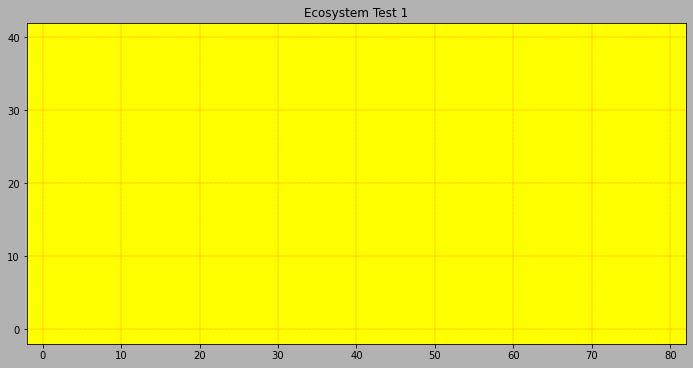

[]
<bound method Ecosystem.register of <__main__.Ecosystem object at 0x0000019360630070>>
24
0
False
0
error      Robot    1732488977856    register required variable 'kind' missing. Robot not registered
error      Droid    1732488921584    register required variable 'kind' missing. Droid not registered
error      Drone    1732488978096    register required variable 'kind' missing. Drone not registered

False
False
False


In [16]:
##############################################################
# @title Test 1 Instantiation [code] {display-mode: "code"} 
##############################################################
#Test 1.
#Instantiate your robots so that they appear in random places when you execute an ecosystem display.
#Test some ecosystem properties such as messages, deregister, count_operational

robot1 = Robot()
droid1 = Droid()
drone1 = Drone()

ecosystem = Ecosystem()
for robots in [robot1, droid1, drone1]:
  ecosystem.register(robots)

ecosystem.display_parameters = {'title' :'Ecosystem Test 1', 'pause': 50, 'annotations' : [(2, 2), 'name','soc', 'coordinates']}
ecosystem.display()
for p in [ecosystem.robots, ecosystem.register, ecosystem.duration, ecosystem.hour, ecosystem.stop, ecosystem.count_operational, ecosystem.messages, ecosystem.message, ecosystem.has_message, ecosystem.display_on_update]:
  print(p)


In [17]:
##############################################################
# @title Test 2 Attributes Zone [code] {display-mode: "code"} 
##############################################################
#Test 2
#Instantiate robots and change attributes. 
# Demonstrate your awareness of robot attributes such as size, colour and shape

#To make robots coordinates as same as ecosystem register
robot1.coordinates = ecosystem.robot_register[id(robot1)]['coordinates']
droid1.coordinates = ecosystem.robot_register[id(droid1)]['coordinates']
drone1.coordinates = ecosystem.robot_register[id(drone1)]['coordinates']
robot1.name = 'robotOne'
droid1.name = 'droidOne'
drone1.name = 'droneOne'
ecosystem.update()
print(ecosystem.messages)
#Test the robot target and move method
ecosystem.display_on_update = False
is_true = True
exit_word = 'break'
while not is_true:
  in_put = input('Robot target in format (x y z): ')
  if in_put == exit_word:
    print('Finished!')
    break
  else:
    try:
      in_put_list = in_put.split(' ')
      target_list = []
      for item in in_put_list:
        target_list.append(int(item))
      robot1.target_p = target_list

      while robot1.coordinates != robot1.target:
        robot1.move()
        ecosystem.update()
        ecosystem.display()
        if ecosystem.has_message:
          print(ecosystem.messages)
      print(f'Robot has reached its target {robot1.target}')
    except Exception as err:
      print(f'There has been an error {err}')
      break



KeyError: 1732488977856

In [ ]:
##############################################################
# @title Test 3 -Robot Factory [code] {display-mode: "code"} 
##############################################################
#Test 3
#Instantiate at least a dozen robots in a loop.
# It is up to you how you arrange them - random or otherwise

how_many_of_each = int(12/3)
my_robot_list = []

#Three previously made robot objects are added

my_robot_list += [robot1, droid1, drone1]

#Easier to work with list of objects than individual objects

for count in range(how_many_of_each):
  my_robot_list += [Robot(), Droid(), Drone()]
for i in my_robot_list:
    ecosystem.register(i)
    i.coordinates = ecosystem.robot_register[id(i)]['coordinates']
    
ecosystem.update()
ecosystem.display()



In [ ]:
ecosystem.display_parameters = {}
ecosystem.display_parameters = {'pause':1,
                                'title':f'robot factory of {ecosystem.count_operational} robots'
                                }

#Test robot factory
exit_word = 'break'
is_true = True
not_finished = True
in_put = ''
while is_true:
  in_put = input('>')
  if in_put == exit_word:
    break
  else:
    for i in my_robot_list:
      i.target_p = [randint(0,default_width), randint(0, default_height), 0]
    while not_finished:
      for i in my_robot_list:
        i.move()
        '''
        if ((i1.coordinates == i1.target) for i1 in my_robot_list):
            not_finished = False
        else:
            pass
        '''
        not_finished = False
      for i in my_robot_list:
        if i.target != i.coordinates:
          not_finished = True
      ecosystem.update()
      ecosystem.display()

### **Preparation for Movement**

If you finish the above begin to design a move  method which changes the ```coordinates``` of a robot. The method should respect the configuration of ```velocity``` (3 vectors, positive or negetive), the maximum **absolute** values of the permitted velocity given by ```max```. Any changes to coordinates, and the system boundary. See the Robot Methods section in Robot Documentation. 

Use your classes above! Your refactoring of the classes work should not break previous tests

In [ ]:
##############################################################
# @title - Robot Targets and Moving [code] {display-mode: "code"} 
##############################################################
#This section not assessed
#Begin to think about furnishing your robot with a move method and target coordinates.






# **Stage 2 - Training and Development**

There are seven exercises in this section.

Some are simple adaptations of the previous, so copy your code forwards.
Create a new ecosystem for each exercise so it is independent of previous code cells.


This section principally involves the development of 'methods' for your robot.

Methods should be fully developed for the parent Robot class, and Droids and Drones should **inherit** these methods. However you should ensure that subtle differences in their attribute values should be respected by the method so that it works correctly for each type of Robot. 

1. Creating Pizzas
1. Target and Move
1. Deliveree
1. Work Till You Drop
1. Factoree Deliveree
1. Charger
1. Factory Delivery and Charging


**Please see slide deck on Stage 2 for guidance on these exercises.**









---



In [ ]:
##############################################################
# @title Creating Pizzas [code] {display-mode: "code"} 
##############################################################
#Instantiate an Ecosystem and test the creation of Pizzas. 
#Make sure you assign your pizza to a variable.
#Explore and comment on the properties of your pizza: coordinates, weight, target.
#Note, there is no cheese.



In [ ]:
##############################################################
# @title Target and Move [code] {display-mode: "code"} 
##############################################################
# Deliver this test code cell  for your working move method
# Instantiate an Ecosystem, create a pizza and assign to a variable.
# Create a Robot, and set the target to the pizza co-ordinates.
# Use the Loop Pattern (slide 9), call move() and update(). 
# A well behaved robot should get to the the pizza. 
# Your move method should work for all three kinds of robot.


In [ ]:
##############################################################
# @title Deliveree [code] {display-mode: "code"} 
##############################################################
# Deliver a delivery code cell. 
# A registered robot enters the loop and is avialable to deliver pizza.
# When delivered move the robot off the pizza and becomes idle. 
# End the loop using the ecosystems count_operational attribute.
# Tip - use the Robot 'busy' activity to move off, but not be given another pizza!

In [ ]:
##############################################################
# @title Work Till You Drop [code] {display-mode: "code"} 
##############################################################
# This exercise is the same as deliveree, but the Robot becomes
# available again and is given a new pizza cargo. It works until it 
# it drops. End the loop gracefully using the count_operational attribute

In [ ]:
##############################################################
# @title Factoree Deliveree [code] {display-mode: "code"} 
##############################################################
# Use the Robot Factory (slide 13) to create a large number of robots
# Convert your Loop Pattern to iterate through all registered robots.
# Each robots gets a pizza and delivers it. After delivery it becomes
# available again. And so it carries on. Work each robot till it drops 
# To iterate through all the robots.
# End the loop gracefully using the count_operational attribute


In [ ]:
##############################################################
# @title Charger [code] {display-mode: "code"} 
##############################################################
# Take a simple one robot scenario and a loop pattern.
# Implement a charging station
# Use a simple charging strategy the percentage SOC (soc/capacity) 
# Should the %SOC be different for each robot type.




In [ ]:
##############################################################
# @title Factory Delivery and Charging [code] {display-mode: "code"} 
##############################################################
# Implement a charging station(s) for a factory scenario
# Use a simple charging strategy based on %SOC
# Can you get your ecosystem to keep going for a thousand hours.
# Do all the robots survive?






# **Stage 3 - Ecosystem Monitoring**

Stage 3 is about extracting some numbers from your ecosystem of robots

By now with completion of **Factory Delivery and Charging** you should have successful ecosystem runs for several hundred hours, even 1000. 
With at least 10 robots delivering and charging. You might be losing some along
the way but don't worry about this.

But how do we know what has quantitatively been done. What data has been created along the way?  There are five data points that are collected for each robot, which you will have seen in the attribute table:


|required    |name       |default   |validation  |datatype    |description                             |
|------------|-----------|----------|------------|------------|----------------------------------------|
|recommended |service    |0         |Read Only   |integer     |service points accrued by robot         |
|recommended |age        |0         |Read Only   |integer     |age of robot in hours                   |
|recommended |active        |0         |Read Only   |integer     |age of robot in hours                   |
|optional    |distance   |0         |Read Only   |float       |distance travelled by robot             |
|optional    |energy     |0         |Read Only   |float       |energy consumed by robot                |

For metrics, make sure that you have these attributes in your parent Robot class. The ecosystem maintains a record in the registry so the data is collected in any case. 

Using these values you can derive:

* $$Average\ \ speed = \frac{distance}{active\ hours} \  (squares.hour^{-1})$$

* $$Service\ \ rate = \frac{service}{active\ hours} \  (kg.hour^{-1})$$

* $$Energy\ \ efficiency\ \  = \frac{Energy}{Service} (kWh.kg^{-1} $$    

* $$Average\ \ Power\ \  = \frac{Energy}{active\ hours}\ \ (kWh.hour^{-1} = kW)$$ 

All the required values are in the registry so lets access that.

For the exercises in this stage take a **copy** of your working **Factory Charging** code cell in stage 2. As with all your code cells this should start with its own ecosystem instantiation. 









In [ ]:
##############################################################
# @title Monitoring of Factory Delivery and Charging [code] {display-mode: "code"} 
##############################################################
'''
Take a fully working copy of your factory delivery and charging code cell
turn off automatic updating of the display.
Make sure you have automatic display on update turned to False: 
ecosystem.display_on_update = False
When you run the code cell you will see how quicky it runs. 
So allowing the duration to be a 1000 hours should have little consequence
'''
ecosystem = Ecosystem()
ecosystem.display_on_update = False

In [ ]:
#@title Ecosystem Registry {display-mode: "code"}
'''
Create a code cell which uses the ecosystem registry to display
summary analysis for each robot kind
'''




In [ ]:
#@title Tabulation {display-mode: "code"}
'''
Create a code cell which displays key metrics, including derived values as 
discussed in stage 3 introduction
See slides on stage 3 for the key attributes you should tabulate
'''


#**Stage 4 - Performance**

This section is less prescriptive than the previous sections.

It requires you to try and improve the performance as monitored by your work in stage 3

The benchmark is the key performance indicators (KPIs) of an ecosystem with 

  * 5 robots of each kind 
  * An ecosystem duration of 1000 hours
  * A maximum of **2** charging stations

##**KPIs**

* $$Robot\ performance = \frac{Active\ hours}{Age} \  (ratio)$$

* $$Service\ \ rate = \frac{Service}{Active\ hours} \  (kg.hour^{-1})$$

* $$Energy\ \ efficiency\ \  = \frac{Energy}{Service} (kWh.kg^{-1} $$    

* $$Average\ \ Power\ \  = \frac{Energy}{Active\ hours}\ \ (kWh.hour^{-1} = kW)$$ 

All these KPIs are affected by the operational efficiency of the Robots and this is determined by
* poor allocation of pizzas to robots - does the nearest Robot get the next pizza!
* poor charging decisions - often a robot has to head for the charger based on a low SOC when 
   1. it may have been able to collect the pizza it was heading for then headed to the charger.
   2. it could have charged as it was passing the charger i.e. before SOC was too low
   3. High risk taking resulting in robot's running out of charge

So there are two things you can do:
1. Smarter allocation of pizzas to robots on a proximity basis.
2. Smarter charging algorithm.


Do not deliver in your submission, additional or new Robot classes.

Any changes you make to your robot classes in stage 1 should not 'break' earlier exercises! 


This section has no specific code cells - please organise as you choose.

If you do incremental improvements with different measures, use a new codecell and show how the improvements unfold.

Document your enhancements, and KPI improvements in the final text cell.










In [ ]:
#@title KPI Improvements [code] {display-mode: "code"}

# Use this code cell and any subsequent ones to develop your KPI improvements



##**KPI Improvement Summary**

Please summarise your KPI improvements here and how you achieved them.

#**Summary and Conclusion**

This coursework should have highlighted the use of OOP in software design. 
Summarise how the 4 main concepts of OOP (see WSA010 JNB08 Structured Programming.ipynb) have been employed in the Robot Ecosystem. Your answer should make specific reference to the objects, methods, attributes and any other code you have deployed in the courswork, and discuss OOPs suitability for this sort of application.

 (500 words minimum - 1000 words maximum)

Create your answer here. You may use markdown but your answer will not be graded on its use.

#**Marking Schema**

***Please use your own work - do not plagiarise***

|                            Section | Deliverable                                 | Marks | Section | Section % |
|-----------------------------------:|---------------------------------------------|:-----:|:-------:|:---------:|
|                      Robot Classes |                                             |       |    12   |    12%    |
|                                    | Robot Class                                 |   4   |         |           |
|                                    | Droid Class                                 |   4   |         |           |
|                                    | Drone Class                                 |   4   |         |           |
|            Stage 1 - Robot Classes |                                             |       |    8    |     8%    |
|                                    | Test 1 Instantiation                        |   2   |         |           |
|                                    | Test 2 Attributes Zone                      |   2   |         |           |
|                                    | Test 3 -Robot Factory                       |   4   |         |           |
| Stage 2 - Training and Development |                                             |       |    32   |    32%    |
|                                    | Creating Pizzas                             |   2   |         |           |
|                                    | Target and Move                             |   4   |         |           |
|                                    | Deliveree                                   |   4   |         |           |
|                                    | Work Till You Drop                          |   4   |         |           |
|                                    | Factoree Deliveree                          |   6   |         |           |
|                                    | Charger                                     |   4   |         |           |
|                                    | Factory Delivery and Charging               |   8   |         |           |
|     Stage 3 - Ecosystem Monitoring |                                             |       |    12   |    12%    |
|                                    | Monitoring of Factory Delivery and Charging |   2   |         |           |
|                                    | Ecosystem Registry                          |   2   |         |           |
|                                    | Tabulation                                  |   8   |         |           |
|              Stage 4 - Performance |                                             |       |    16   |    16%    |
|                                    | KPI Improvements                            |   10  |         |           |
|                                    | KPI Improvement Summary                     |   6   |         |           |
|             Summary and Conclusion |                                             |       |    8    |     8%    |
|                                    | 500-1000 words                              |   8   |         |           |
|             Python Code Evaluation |                                             |       |    12   |    12%    |
|                                    | Structured Code                             |   8   |         |           |
|                                    | Readable code                               |   4   |         |           |
|                                    |                                             |       |         |           |
|                                    | Total                                       |  100  |   100   |    100%   |